In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm, colors
import glob
from collections import defaultdict, Counter

from numba import njit, vectorize, float32

from typing import Callable, Optional, Union

import hoomd
import gsd.hoomd

import sys
import time
import pickle
import gc

import signac
import freud
import networkx as nx

In [2]:
from monk import nb, prep, pair, render, utils, workflow, grid


config = workflow.get_config()

/home/ian/Projects/work/monk/.venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
project: signac.Project = signac.get_project(root=config['root'])
project.doc

{'ref_sim_temps': [0.41, 0.43, 0.45, 0.47, 0.49, 0.51, 0.53, 0.55, 0.58, 0.61, 0.64, 0.67, 0.7, 0.75, 0.8, 0.9, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0], 'avail_seed': 18, 'alpha_iters': 40, 'dt': 0.001, 'usteps': 1000}

{'N': 32768, 'replica': 2, 'delta': 0.0, 'phi': 1.2}
/media/ian/Data2/monk/mlj-production/workspace/e0e449dbb710b9bd88a01339bcca2881/runs/temp-0.45/traj.gsd
[7136430]


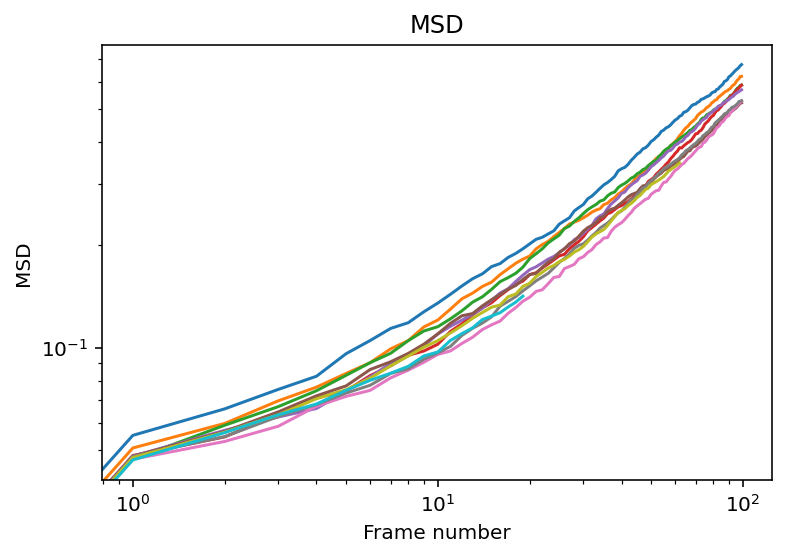

In [33]:
for job in project.find_jobs({'delta': 0.0}):
    print(job.sp)
    runs = sorted(glob.glob(job.fn("runs/temp-*/traj.gsd")))
    # print(runs)
    for run in runs:
        print(run)
        traj = gsd.hoomd.open(run)
        print(traj[-1].log["Simulation/timestep"] - traj[0].log["Simulation/timestep"])
        box = freud.box.Box.from_box(traj[0].configuration.box)
        msd = freud.msd.MSD(mode="direct")
        fig, ax = plt.subplots()
        for start in np.linspace(0, len(traj)-200, 10, dtype=int):
            pos0 = traj[int(start)].particles.position
            pos = []
            for frame in traj[start:start+1000:10]:
                pos.append(box.wrap(frame.particles.position - pos0))
            
            msd.compute(pos, reset=True)
            msd.plot(ax=ax)
        plt.xscale('log')
        plt.yscale('log')
        break
    break

In [23]:
traj[0].log["Simulation/timestep"]

array([10420398])

In [8]:
def sisf(dx, k=7.14):
    x = k * np.linalg.norm(dx, axis=-1)
    sisf = np.mean(np.sin(x)/x)
    return sisf

{'N': 32768, 'replica': 0, 'delta': 0.1, 'phi': 1.18}
{'N': 32768, 'replica': 0, 'delta': 0.4, 'phi': 1.12}
{'N': 32768, 'replica': 0, 'delta': 0.2, 'phi': 1.16}
{'N': 32768, 'replica': 0, 'delta': 0.0, 'phi': 1.2}
{'N': 32768, 'replica': 0, 'delta': 0.3, 'phi': 1.14}
{'N': 32768, 'replica': 0, 'delta': 0.5, 'phi': 1.1}
/media/ian/Data2/monk/mlj-production/workspace/95b2607f9dd4ae5e276743426b666e10/runs/temp-2.21/traj.gsd
/media/ian/Data2/monk/mlj-production/workspace/95b2607f9dd4ae5e276743426b666e10/runs/temp-2.30/traj.gsd


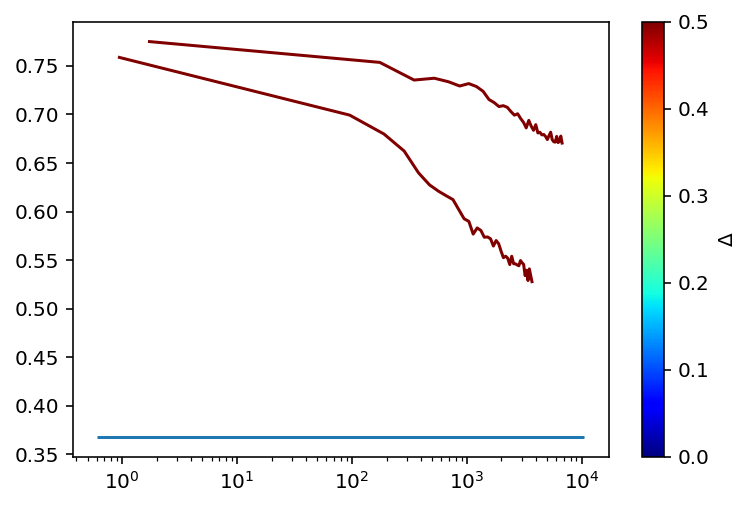

In [98]:
fig, ax = plt.subplots()

for job in project.find_jobs({'replica': 0}):
    cmap = cm.jet
    norm = colors.Normalize(0, 0.5)
    print(job.sp)
    runs = sorted(glob.glob(job.fn("runs/temp-*/traj.gsd")))
    # print(runs)
    for run in runs[0:]:
        # print(run)
        traj = gsd.hoomd.open(run)
        # print(traj[-1].log["Simulation/timestep"] - traj[0].log["Simulation/timestep"])
        box = freud.box.Box.from_box(traj[0].configuration.box)
        _colors = ["r", "g", "b", "y", "m"]
        for start in [0]:
            pos0 = traj[int(start)].particles.position
            pos = []
            sisfs = []
            tsteps = []
            tstep0 = traj[int(start)].log["Simulation/timestep"]
            for frame in traj[start+1::100]:
                new_pos = box.wrap(frame.particles.position - pos0)
                pos.append(new_pos)
                sisfs.append(sisf(new_pos))
                tsteps.append((frame.log["Simulation/timestep"] - tstep0) * project.doc["dt"])
            # msd.compute(pos, reset=True)
            # msd.plot(ax=ax)
            sisfs = np.array(sisfs)

            if np.any(sisfs < np.exp(-1)):
                continue
            print(run)
            plt.plot(tsteps, sisfs, color=cmap(norm(job.sp["delta"])))
            # ax.get_lines()[-1].set_color(_c)
        # break
    # break
plt.xscale('log')
# plt.yscale('log')
plt.hlines(np.exp(-1), *plt.xlim())
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), label=r"$\Delta$")

In [37]:
job.id

'553cdedf027c7751d543faafac4917c3'

In [42]:
job.doc["alpha_ests"]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0354841942940312, 1.3397690122883383, 1.9147213152655829, 2.427651106103333, 3.2650328444742174, 4.051542695887625, 5.218161511196287, 7.044415153987661, 10.10020001455888, 15.65947793481358, 22.171066058445877, 33.176064452520336, 53.117878466989104, 92.44383930410444, 178.47690107882985, 392.5634880273459, 1018.9213055070264]

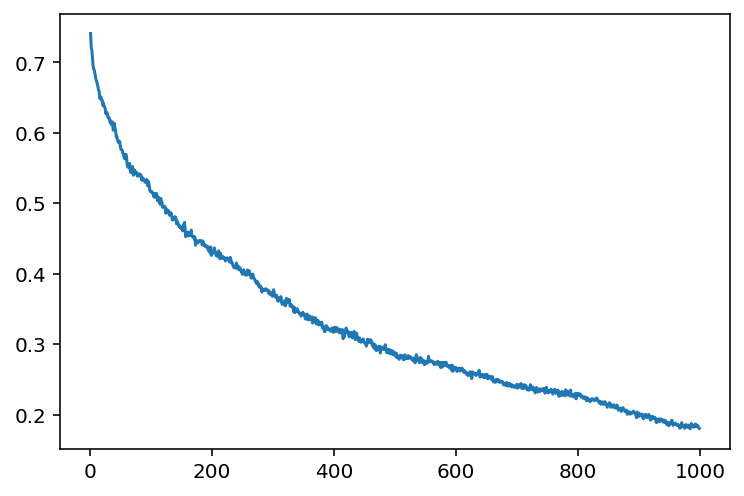

In [49]:
plt.plot(sisfs)

In [48]:
def nearest_neighbors(traj: gsd.hoomd.HOOMDTrajectory):
    box = freud.box.Box.from_box(traj[0].configuration.box)
    frame = traj[0]
    points = frame.particles.position
    aq = freud.AABBQuery(box, points)
    nl = aq.query(points, {"num_neighbors": 12, "exclude_ii": True}).toNeighborList()
    common_neighbors = defaultdict(list)
    for i, p in enumerate(points):
        for j in nl.point_indices[nl.query_point_indices == i]:
            for k in nl.point_indices[nl.query_point_indices == j]:
                if i != k:
                    common_neighbors[(i, k)].append(j)
    diagrams = defaultdict(list)
    particle_counts = defaultdict(Counter)

    for (a, b), neighbors in common_neighbors.items():
        # Build up the graph of connections between the
        # common neighbors of a and b.
        g = nx.Graph()
        for i in neighbors:
            for j in set(nl.point_indices[nl.query_point_indices == i]).intersection(
                neighbors
            ):
                g.add_edge(i, j)

        # Define the identifiers for a CNA diagram:
        # The first integer is 1 if the particles are bonded, otherwise 2
        # The second integer is the number of shared neighbors
        # The third integer is the number of bonds among shared neighbors
        # The fourth integer is an index, just to ensure uniqueness of diagrams
        diagram_type = 2 - int(b in nl.point_indices[nl.query_point_indices == a])
        key = (diagram_type, len(neighbors), g.number_of_edges())
        # If we've seen any neighborhood graphs with this signature,
        # we explicitly check if the two graphs are identical to
        # determine whether to save this one. Otherwise, we add
        # the new graph immediately.
        if key in diagrams:
            isomorphs = [nx.is_isomorphic(g, h) for h in diagrams[key]]
            if any(isomorphs):
                idx = isomorphs.index(True)
            else:
                diagrams[key].append(g)
                idx = diagrams[key].index(g)
        else:
            diagrams[key].append(g)
            idx = diagrams[key].index(g)
        cna_signature = key + (idx,)
        particle_counts[a].update([cna_signature])
    return particle_counts

In [50]:
particle_counts = nearest_neighbors(traj)

KeyboardInterrupt: 

In [82]:
for job in project.find_jobs({"delta": 0.5}, {"_CRYSTAL": {"$exists": False}}):
    print(job.sp)
    job.doc["_CRYSTAL"] = True
    # print(job.doc)